In [1]:
import fastText
import train_embeddings
import sentence_features
import pickle
from random import shuffle
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
# Load mapped reports
labeled_reports_path = "../data/processed/processed_reports/preprocessed_all_replace_sw"
mapped_reports = pickle.load(open(labeled_reports_path, 'rb'))

In [3]:
# Convert mapped reports to correct format
mapped_report_strs = []
for mr in mapped_reports:
    report_string = " ".join(mr[0]).replace("\n", " ")
    label = " __label__" + str(mr[1])
    mapped_report_strs.append(report_string + label)
shuffle(mapped_report_strs)

In [4]:
split_point = int(0.9 * len(mapped_report_strs))
train = mapped_report_strs[:split_point]
test = mapped_report_strs[split_point:]

test_data = [t.split("__label__")[0] for t in test]
test_labels = [int(t.split("__label__")[1]) for t in test]

train_path = "../data/processed/processed_reports/ftTRAIN"
with open(train_path, 'w') as outfile:
    for mrs in train:
        outfile.write(mrs)
        outfile.write("\n")

In [5]:
# Train classifier
dim = 100
ng = 3
model = fastText.train_supervised(train_path, dim=dim, epoch=10, thread=4, neg=8, lr=0.05, wordNgrams=ng)

In [6]:
model.get_words()

['right',
 'left',
 '</s>',
 'unremarkable',
 'normal',
 'RISK',
 'SCREEN',
 'within',
 'mild',
 'small',
 'bilateral',
 'NEGEX_evidence',
 'unchanged',
 'soft',
 'lower',
 'measuring',
 'prior',
 'lobe',
 'seen',
 'tissues',
 'ct',
 'visualized',
 'fluid',
 'upper',
 'size',
 'posterior',
 'post',
 'likely',
 'interval',
 'mass',
 'lung',
 'pain',
 'measures',
 'spine',
 'anterior',
 'image',
 'bones',
 'changes',
 'PT',
 'disease',
 'liver',
 'vein',
 'artery',
 'NEGEX_acute',
 'lesion',
 'lateral',
 'disc',
 'series',
 'compared',
 'moderate',
 'status',
 'findings',
 'l5',
 'gallbladder',
 'HX',
 'patent',
 'new',
 'pulmonary',
 'fracture',
 'collection',
 'chest',
 'tissue',
 'increased',
 'narrowing',
 'vertebral',
 'renal',
 'inferior',
 'none',
 'noted',
 'pleural',
 'lungs',
 'bowel',
 'NEGEX_suspicious',
 'joint',
 'distal',
 'kidneys',
 'abdomen',
 'multiple',
 'age',
 'represent',
 'edema',
 'space',
 'cervical',
 'hepatic',
 'appearance',
 'l4',
 'bladder',
 'large',
 'flo

In [7]:
# Make predictions
predictions = [model.predict(s) for s in test_data]
confs = [1 - p[1][0] if p[0][0] == '__label__0' else p[1][0] for p in predictions]

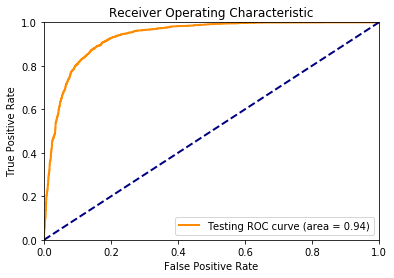

Precision at .9 recall: 0.80


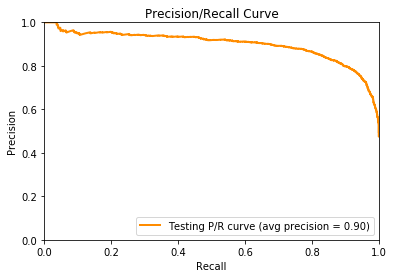

In [8]:
fpr, tpr, thresholds = roc_curve(test_labels, confs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(test_labels, confs)
avg_prec = average_precision_score(test_labels, confs)

r90_index = [i for i, r in enumerate(recall) if r > .9][-1]
p_at_r90 = precision[r90_index]
print('Precision at .9 recall: %0.2f' % p_at_r90)

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Testing P/R curve (avg precision = %0.2f)' % avg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [9]:
model_name = "ft" + str(dim) + "_" + str(ng) + ("_%0.2f" % roc_auc) + ".bin"
model.save_model("../data/models/fastText/classify/" + model_name)

In [ ]:
epochs = [1, 2, 3] + list(range(5, 45, 5))

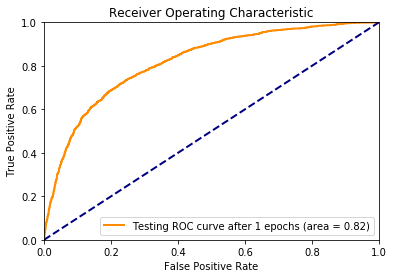

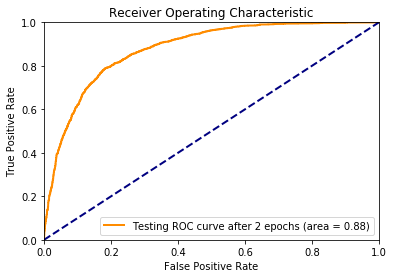

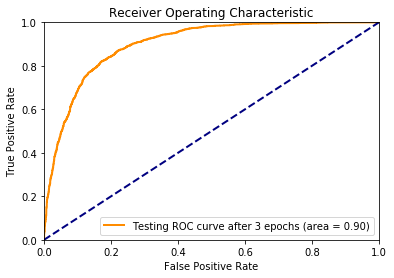

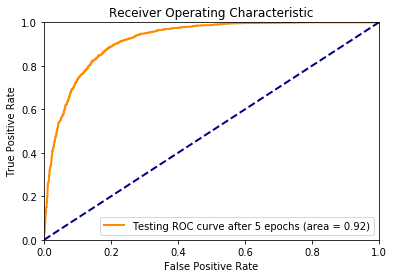

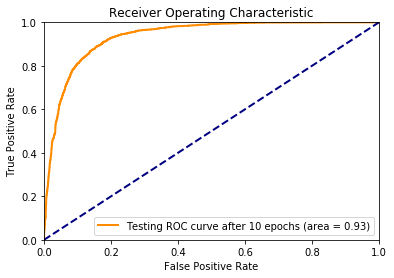

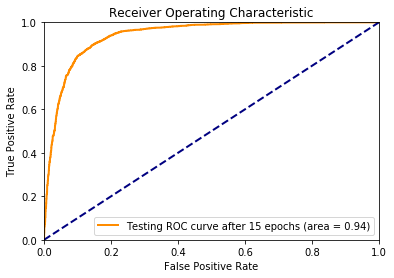

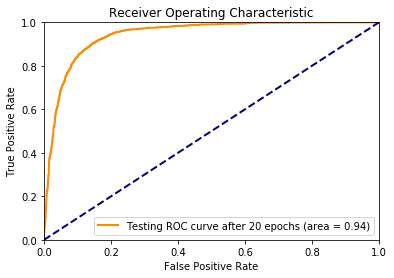

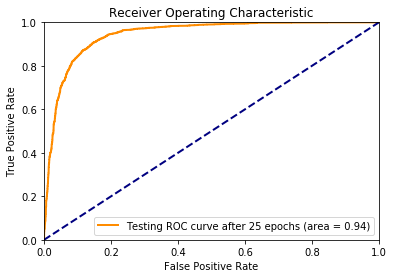

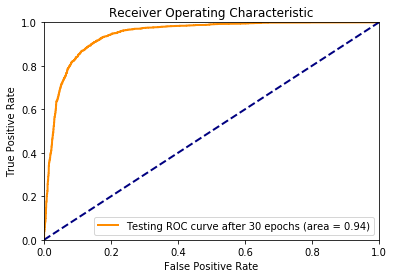

In [ ]:
for e in epochs:
    model = fastText.train_supervised(train_path, dim=300, epoch=e, thread=4, neg=8, lr=0.05, wordNgrams=3)
    predictions = [model.predict(s) for s in test_data]
    confs = [1 - p[1][0] if p[0][0] == '__label__0' else p[1][0] for p in predictions]
    
    fpr, tpr, thresholds = roc_curve(test_labels, confs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Testing ROC curve after ' + str(e) + ' epochs (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()